**Import Packages and Datas**

In [715]:
import pandas as pd 
import numpy as np 
import talib as ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.metrics import accuracy_score 
import xgboost as xgb
import pywt
import matplotlib.pyplot as py 
import seaborn as sns 
sns.set_theme() 

import warnings
warnings.filterwarnings('ignore')

In [716]:
data = pd.read_csv('//Users//wangtingxuan//Desktop//Trading//Data//1d//btc.csv')

# 創建一個新的target欄位，表示相對於前一天的漲跌情況
data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
data


,Time,Open,High,Low,Close,Volume,Target
0,2021-01-01 08:00:00,28923.63,29600.00,28624.57,29331.69,54182.925011,1
1,2021-01-02 08:00:00,29331.70,33300.00,28946.53,32178.33,129993.873362,1
2,2021-01-03 08:00:00,32176.45,34778.11,31962.99,33000.05,120957.566750,0
3,2021-01-04 08:00:00,33000.05,33600.00,28130.00,31988.71,140899.885690,1
4,2021-01-05 08:00:00,31989.75,34360.00,29900.00,33949.53,116049.997038,1
...,...,...,...,...,...,...,...
1173,2024-03-19 08:00:00,67610.00,68124.11,61555.00,61937.40,101005.324870,1
1174,2024-03-20 08:00:00,61937.41,68100.00,60775.00,67840.51,90420.585920,0
1175,2024-03-21 08:00:00,67840.51,68240.47,64529.01,65501.27,53357.480020,0
1176,2024-03-22 08:00:00,65501.28,66649.62,62260.00,63796.64,51482.378210,1


**Calculate Technical Indicators**

In [717]:
close_prices = data['Close'].values 
high_prices = data['High'].values
low_prices = data['Low'].values

# RSI
rsi_period = 14 
rsi_values = ta.RSI(close_prices, timeperiod=rsi_period)
data['RSI'] = rsi_values

# MACD
macd, signal_line, _ = ta.MACD(close_prices)
data['MACD'] = macd
data['Signal_Line'] = signal_line

# ADX
adx = ta.ADX(high_prices, low_prices, close_prices, timeperiod=14)
data['ADX'] = adx

# Momentum
momentum = ta.MOM(close_prices, timeperiod=12)
data['Momentum'] = momentum

# CCI
cci = ta.CCI(high_prices, low_prices, close_prices, timeperiod=20)
data['CCI'] = cci

# PPO
ppo = ta.PPO(close_prices, fastperiod=12, slowperiod=26, matype=0)
data['PPO'] = ppo

# ROC
roc = ta.ROC(close_prices, timeperiod=12)
data['ROC'] = roc

# Stochastic Oscillator
k, d = ta.STOCH(high_prices, low_prices, close_prices, fastk_period=5, slowk_period=3, slowd_period=3)
data['%K'] = k
data['%D'] = d

# William %R 
williams_r = ta.WILLR(high_prices, low_prices, close_prices, timeperiod=14)
data['Williams %R'] = williams_r

# SMA 
sma20 = ta.SMA(close_prices, timeperiod=20)
data['SMA20'] = sma20

sma50 = ta.SMA(close_prices, timeperiod=50)
data['SMA50'] = sma50

# EMA
ema20 = ta.EMA(close_prices, timeperiod=20)
data['EMA20'] = ema20

ema50 = ta.EMA(close_prices, timeperiod=50)
data['EMA50'] = ema50

# Bollinger Bands
upper_band, middle_band, lower_band = ta.BBANDS(close_prices, timeperiod=20, nbdevup=2, nbdevdn=2)
data['UpperBand'] = upper_band
data['MiddleBand'] = middle_band
data['LowerBand'] = lower_band

# PSAR
psar = ta.SAR(high_prices, low_prices)
data['PSAR'] = psar 

# OBV 
data['OBV'] = ta.OBV(data['Close'], data['Volume'])

# ATR 
atr = ta.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
data['ATR'] = atr

data = data.dropna().reset_index().drop(columns=['index'])

**Principal Component Analysis**

In [718]:
train_size = 681 # 2022/12/31以前都是訓練集, 2022/12/31以後包含驗證集和測試集
train_data, test_data = data.drop(columns=['Time', 'Target']).iloc[:train_size], data.drop(columns=['Time', 'Target']).iloc[train_size:]
scaler = MinMaxScaler() 
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data) # 這邊注意是拿訓練集的資料去fit min-max scaler再去對驗證集和測試集做transform 

scaled_train_df = pd.DataFrame(scaled_train_data, columns=train_data.columns, index=train_data.index)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=test_data.columns, index=test_data.index)

normalized_df = pd.concat([scaled_train_df, scaled_test_df])
normalized_df

,Open,High,Low,Close,Volume,RSI,MACD,Signal_Line,ADX,Momentum,...,SMA20,SMA50,EMA20,EMA50,UpperBand,MiddleBand,LowerBand,PSAR,OBV,ATR
0,0.691306,0.760235,0.694319,0.775439,0.085722,0.978475,0.946424,0.914615,0.525233,1.000000,...,0.587684,0.491405,0.618161,0.506295,0.769380,0.587684,0.375544,0.597179,0.997293,0.630368
1,0.775439,0.785526,0.756466,0.774186,0.087452,0.974596,0.972483,0.944058,0.567534,0.804627,...,0.612124,0.503446,0.639483,0.522595,0.791316,0.612124,0.400882,0.630542,0.985959,0.635633
2,0.774186,0.797908,0.788265,0.804477,0.056868,1.000000,1.000000,0.974041,0.608758,0.843523,...,0.637782,0.514906,0.661994,0.539723,0.813172,0.637782,0.428832,0.658288,0.994103,0.626605
3,0.804550,0.781882,0.633464,0.740298,0.158698,0.812847,0.989569,0.995590,0.573042,0.799867,...,0.657788,0.524484,0.675539,0.553071,0.820246,0.657788,0.462082,0.801076,0.975338,0.719717
4,0.740298,0.718774,0.579678,0.639869,0.206161,0.593306,0.934647,1.000000,0.521973,0.586229,...,0.669898,0.532161,0.677121,0.561032,0.815927,0.669898,0.492096,0.801076,0.951623,0.797558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,1.001627,0.983375,0.908025,0.892000,0.114378,0.442120,0.811018,1.015178,0.742981,0.437801,...,1.083481,0.895089,1.049106,0.987685,1.101303,1.083481,1.019555,1.063205,0.252856,0.695685
1125,0.892000,0.982917,0.892654,1.006081,0.100168,0.603843,0.794961,0.983039,0.695200,0.555426,...,1.090689,0.906398,1.054033,0.996338,1.097746,1.090689,1.038554,1.047021,0.265516,0.746783
1126,1.006082,0.985584,0.966630,0.960874,0.050412,0.535976,0.760514,0.949281,0.649472,0.490805,...,1.094034,0.916809,1.053686,1.002461,1.094319,1.094034,1.049411,1.026952,0.258046,0.741922
1127,0.960874,0.955388,0.921918,0.927931,0.047895,0.489198,0.717087,0.912130,0.622902,0.430811,...,1.095978,0.926218,1.049871,1.006749,1.090806,1.095978,1.057470,1.008890,0.250837,0.747225


In [719]:
pca = PCA(n_components=5)
train_normalized_df = normalized_df[:train_size]
test_normalized_df = normalized_df[train_size:]
pca.fit(train_normalized_df) # 這邊也是一樣，用pca去fit訓練集並對驗證集和測試集做transform 

# 轉換數據至新的特徵空間
pca_data1 = pca.transform(train_normalized_df)
pca_data2 = pca.transform(test_normalized_df)

# 將轉換後的數據存入dataframe
pca_df1 = pd.DataFrame(data=pca_data1, columns=[f'PC{i}' for i in range(1, 6)])
pca_df2 = pd.DataFrame(data=pca_data2, columns=[f'PC{i}' for i in range(1, 6)])
pca_df = pd.concat([pca_df1, pca_df2]).reset_index().drop(columns=['index'])

# 查看解釋的方差比例 
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance_ratio) 

pca_df['Time'] = data['Time']
pca_df['Target'] = data['Target']
pca_df

Explained variance ratio: [0.67677986 0.1727047  0.06637156 0.02264552 0.01733925]


,PC1,PC2,PC3,PC4,PC5,Time,Target
0,0.824262,1.259116,-0.219713,0.427629,0.269161,2021-02-19 08:00:00,0
1,0.910286,1.126576,-0.209166,0.328934,0.413708,2021-02-20 08:00:00,1
2,0.991687,1.193920,-0.199997,0.366784,0.424118,2021-02-21 08:00:00,0
3,0.981907,0.868369,-0.288974,0.286499,0.543495,2021-02-22 08:00:00,0
4,0.882279,0.348101,-0.365247,0.130607,0.675544,2021-02-23 08:00:00,1
...,...,...,...,...,...,...,...
1124,1.799198,-0.506881,-0.606071,0.108004,0.707139,2024-03-19 08:00:00,1
1125,1.851453,-0.103068,-0.476027,0.226311,0.412785,2024-03-20 08:00:00,0
1126,1.882604,-0.180976,-0.421574,0.049888,0.500385,2024-03-21 08:00:00,0
1127,1.833641,-0.244799,-0.310343,-0.134121,0.598717,2024-03-22 08:00:00,1


**Discrete Wavalet Transform (Not added yet)**

In [709]:
wavelet = 'db4'
level = 5
coefficients = pywt.wavedec(pca_df['PC1'], wavelet, level=level)
for i in range(len(coefficients)):
    print(f'Details coefficients at level {i}: {coefficients[i]}')

Details coefficients at level 0: [ 5.1448771   5.17121027  5.16899859  5.14204379  5.20175949  5.03386848
  7.59762747  7.57515549  1.85482798 -1.6028971   1.1111534   3.12700971
  5.41805901  9.51683486  6.4117288   2.4894423   1.01255363  1.7264267
  1.5130016  -1.66045957 -5.64049202 -6.3439841  -7.01761821 -7.84528781
 -7.96836176 -9.04004844 -9.1962701  -6.8802543  -7.09699771 -4.83706296
 -4.79184657 -5.20956943 -4.04996391 -4.68256461 -5.60648585 -4.68205908
 -1.85148058  0.91169765  0.56598669  4.18789419  9.89887919 11.09744474]
Details coefficients at level 1: [-0.00865987 -0.01746048  0.22464415  0.4903292  -0.07262717 -0.12826222
  0.5387692  -0.62985623  0.4366651  -1.25720553  1.10680078 -0.47270457
  0.33562742 -0.46472801 -0.01535964  0.59440863 -0.13000601  0.76047351
 -0.24417204  0.41688454 -0.14596251 -0.13596498 -0.2400767   0.22237337
  0.32370454 -0.09413629  0.30071383 -0.17509446  0.0013569   0.32224465
 -0.27070067 -0.16375291  0.20321705  0.49002195 -0.206030

**XGBoost**

In [720]:
# 選擇特徵列
feature_cols = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']

# 分割數據集為特徵和目標變量
X = pca_df[feature_cols]
y = pca_df['Target'] 

# 劃分訓練集,驗證集和測試集
train_size = 681 # 2023/1/1 
validation_size = 862 # 2023/7/1 
train_data = pca_df.iloc[:train_size]
validation_data = pca_df.iloc[train_size:validation_size]
test_data = pca_df.iloc[validation_size:]

X_train, y_train = train_data.drop(columns=['Target', 'Time']), train_data['Target']
X_valid, y_valid = validation_data.drop(columns=['Target', 'Time']), validation_data['Target']
X_test, y_test = test_data.drop(columns=['Target', 'Time']), test_data['Target']

# 初始化 XGBoost 分類器
clf = xgb.XGBClassifier() 

# 定義要嘗試的參數組合
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    # 'min_child_weight': [1, 5, 10],
    # 'subsample': [0.7, 0.8, 0.9],
    # 'colsample_bytree': [0.7, 0.8, 0.9],
    # 'reg_lambda': [0, 0.1, 0.5],
    # 'gamma': [0, 0.1, 0.2],
    # 'reg_alpha': [0, 0.1, 0.5],
    
}

# 使用 Grid Search 進行參數搜索
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=10, verbose=False)
print("Best Parameters:", grid_search.best_params_)

# 在測試集上進行預測
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test) 
train_pred = best_model.predict(X_train)
valid_pred = best_model.predict(X_valid)

# 計算準確率
accuracy = accuracy_score(y_test, y_pred) 
print("Accuracy:", accuracy)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'reg_lambda': 0.1, 'subsample': 0.9}
Accuracy: 0.5131086142322098


**Backtesting**

In [725]:
# 整理dataframe供回測用 
all_sample = pd.concat([pd.Series(train_pred), pd.Series(valid_pred), pd.Series(y_pred)], ignore_index=True)
backtest_df = data[['Time','Close']]#.iloc[862:].reset_index().drop(columns=['index'])
backtest_df['Signal'] = pd.Series(all_sample)
backtest_df

,Time,Close,Signal
0,2021-02-19 08:00:00,55906.00,0
1,2021-02-20 08:00:00,55841.19,0
2,2021-02-21 08:00:00,57408.57,0
3,2021-02-22 08:00:00,54087.67,1
4,2021-02-23 08:00:00,48891.00,0
...,...,...,...
1124,2024-03-19 08:00:00,61937.40,0
1125,2024-03-20 08:00:00,67840.51,0
1126,2024-03-21 08:00:00,65501.27,0
1127,2024-03-22 08:00:00,63796.64,0


********************交易紀錄********************
buy at  54087.67
sell at  48891.0
profit =  -4994.324344161986
buy at  48440.65
sell at  50349.37
profit =  1766.2231617453533
buy at  48374.09
sell at  52375.17
profit =  3927.2898777010605
buy at  55605.2
sell at  58912.97
profit =  2768.386463855902
buy at  58030.01
sell at  58102.28
profit =  -137.85503397294195
buy at  54083.25
sell at  54340.89
profit =  37.71197182121951
buy at  55025.59
sell at  55817.14
profit =  517.8177462522465
buy at  55777.63
sell at  57635.47
profit =  1462.068036953169
buy at  58202.01
sell at  59129.99
profit =  595.611732309585
buy at  55953.45
sell at  58077.52
profit =  1694.272703470474
buy at  55633.14
sell at  56425.0
profit =  510.25676422362693
buy at  31584.45
sell at  34700.34
profit =  4722.767722724308
buy at  31520.07
sell at  31778.56
profit =  209.22025236619336
buy at  38207.05
sell at  44572.54
profit =  8113.595291968362
buy at  46760.62
sell at  49322.47
profit =  2533.8455948616574
buy at

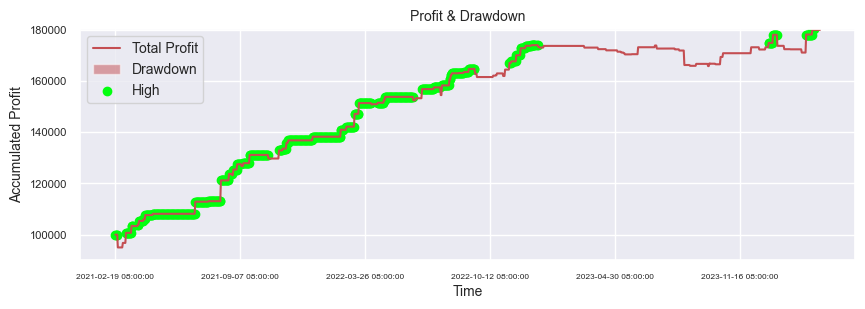

In [726]:
buy_price = [] #買入價格
buy_fee = [] #買入手續費
equity = [] #總權益
win_loss = [] #計算策略勝率
initial = 100000 #初始資金
amount = 50000 #每次下單金額
profit = 0 #平倉時的獲利
trade = 0 #交易次數
position = 0 #當前持倉情況
coin = 0 #買入顆數
fee_rate = 0.002 #手續費率

days = backtest_df.shape[0] 

equity.append(initial)
print("********************交易紀錄********************")
for i in range(0, days):
    if position==0:
        if backtest_df['Signal'].iloc[i]==1:
            buy_price.append(backtest_df['Close'].iloc[i])
            buy_fee.append(amount*fee_rate)
            position = 1
            profit = 0
            coin = amount/backtest_df['Close'].iloc[i]
            equity.append(equity[-1]+profit)
            trade = trade + 1
            print("buy at ",backtest_df['Close'].iloc[i])
        else:
            profit = 0 
            equity.append(equity[-1]+profit)
    
    else:
        if backtest_df['Signal'].iloc[i]==1:
            profit = 0 
            equity.append(equity[-1]+profit)
        else:
            # 利潤=投入金額＊（期間漲跌）- 買入手續費 - 平倉手續費
            profit = amount*(backtest_df['Close'].iloc[i]-buy_price[-1])/buy_price[-1] - buy_fee[-1] - coin*backtest_df['Close'].iloc[i]*fee_rate
            if profit>0:
                win_loss.append(1)
            else:
                win_loss.append(0)

            equity.append(equity[-1]+profit)
            position = 0 
            print("sell at ",backtest_df['Close'].iloc[i])
            print("profit = ",profit)

## 績效計算
print("====================交易績效====================")
drawdown = pd.Series(equity)/pd.Series(equity).cummax()-1
print("總報酬率：",(equity[-1]-initial)/initial)
print("最大回撤：",abs(drawdown.min()))
print("勝率：",np.mean(win_loss))
print("交易次數: ",trade)

eq = pd.DataFrame({'equity':equity[1:]}, index=backtest_df['Time'])
eq['drawdown_percent'] = (eq['equity'] / eq['equity'].cummax()) - 1
eq['drawdown'] = eq['equity'] - eq['equity'].cummax()

fig, ax = py.subplots(figsize = (10,3))
high_index = eq[eq['equity'].cummax() == eq['equity']].index
eq['equity'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
py.fill_between(eq['drawdown'].index, eq['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
py.scatter(high_index, eq['equity'].loc[high_index],c = '#02ff0f', label = 'High')

py.legend(fontsize=10)
py.ylabel('Accumulated Profit', fontsize=10)
py.ylim(initial-10000, eq['equity'].max())
py.tick_params(axis='y', labelsize=8)
py.xlabel('Time', fontsize=10)
py.tick_params(axis='x', labelsize=6)
py.title('Profit & Drawdown',fontsize  = 10)
py.show() 


